## Data importing

In [1]:
paths = ["./data/s" + str(i) for i in range(1, 41)]
print(paths[0])
print(paths[1])

./data/s1
./data/s2


(92, 112)


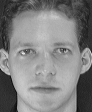

In [2]:
from PIL import Image
img = Image.open('./data/s1/1.pgm')
print(img.size)
img

## Converting to Matrix

In [3]:
import os
import numpy as np

data = []

for path in paths:
    files = os.listdir(path)

    for file in files:
        img = Image.open(path + "/" + file)
        img = np.array(img)
        img = img.flatten()
        data.append(img)
        
data = np.array(data)
data.shape

(400, 10304)

In [4]:
labels = []

for i in range(1, 41):
    tmp = [i] * 10
    labels += tmp

labels = np.array(labels)
labels.shape

(400,)

## Data splitting

In [5]:
x_train = []
x_test = []
y_train = []
y_test = []

for i in range(data.shape[0]):
    if (i+1) % 2 == 0:
        x_test.append(data[i])
        y_test.append(labels[i])
    else:
        x_train.append(data[i])
        y_train.append(labels[i])

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(200, 10304)
(200, 10304)
(200,)
(200,)


## Classification using PCA

In [6]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

def PCA(D, alphas, mu):
    results = {}
    #mu = np.mean(D, axis=0)
    z = D - mu
    sigma =np.cov(z, rowvar=False)

    eigen_values, eigen_Vectors = np.linalg.eigh(sigma)
    total_variance = np.sum(eigen_values)

    for alpha in alphas:
        r = np.argmax(np.cumsum(eigen_values[::-1]) / total_variance >= alpha)

        u_r = eigen_Vectors[:, -r-1:]
        A = np.dot(u_r.T, z.T)
        results[alpha] = (u_r, A)
    return results

In [7]:
alphas = [0.8, 0.85,0.9, 0.95]

mu = np.mean(x_train, axis=0)
training_set = PCA(x_train, alphas, mu)


knn = KNeighborsClassifier(n_neighbors=1)

accuracies = {}
for alpha, (u_r, A) in training_set.items():
    projected_training = A.T
    projected_tes = np.dot(u_r.T, (x_test - mu).T).T

    knn.fit(projected_training, y_train)

    predicted_labels =knn.predict(projected_tes)

    accuracy = np.mean(predicted_labels == y_test)
    accuracies[alpha] = accuracy

for alpha, accuracy in accuracies.items():
    print(f'Accuracy for alpha: {alpha}: {accuracy:.2f}')

Accuracy for alpha: 0.8: 0.94
Accuracy for alpha: 0.85: 0.94
Accuracy for alpha: 0.9: 0.94
Accuracy for alpha: 0.95: 0.94


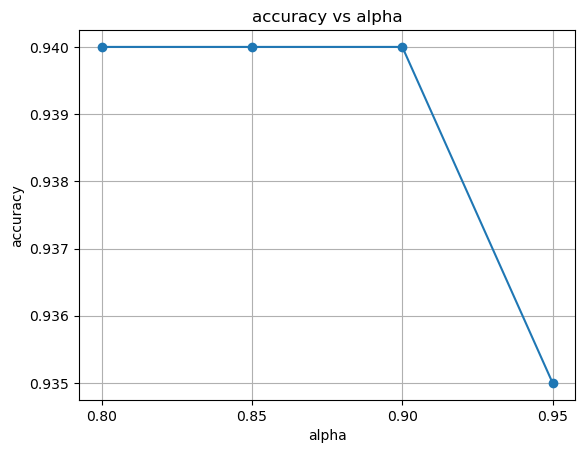

In [8]:
import matplotlib.pyplot as plt

alpha_values = list(accuracies.keys())
accuracy_score = list(accuracies.values())

plt.plot(alpha_values, accuracy_score, marker='o')
plt.title('accuracy vs alpha')
plt.xlabel('alpha')
plt.ylabel('accuracy')
plt.grid(True)
plt.xticks(alpha_values)

plt.show()


## Classification using LDA

### LDA Algorithm

In [9]:
def LDA(X, y):
    # Separate the dataset into class-specific subsets
    classes = np.unique(y)
    n_features = X.shape[1]
    
    # Compute the overall mean
    overall_mean = np.mean(X, axis=0)
    
    # Compute the class means and between-class scatter matrix
    B = np.zeros((n_features, n_features))
    class_means = {}
    for c in classes:
        class_means[c] = np.mean(X[y == c], axis=0)
        n_c = X[y == c].shape[0]
        mean_diff = (class_means[c] - overall_mean).reshape(n_features, 1)
        B += n_c * (mean_diff @ mean_diff.T) # @ is a matrix multiplication operator
    
    # Compute the within-class scatter matrix
    S = np.zeros((n_features, n_features))
    for c in classes:
        Z = X[y == c] - class_means[c]
        S += Z.T @ Z
    
    # Solve the eigenvalue problem for S^(-1)B
    eigenvalues, eigenvectors = np.linalg.eigh(np.linalg.inv(S) @ B)
    
    # Sort eigenvectors by eigenvalues in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, sorted_indices]
    
    return eigenvectors

### Getting Eigen vectors

In [10]:
eigen_vectors = LDA(x_train, y_train)
print(eigen_vectors[0:3])

[[ 0.00652133 -0.00539612  0.01021945 ... -0.01045777  0.00580433
  -0.00648884]
 [ 0.0066049  -0.00538013  0.01029594 ... -0.01055159  0.00579431
  -0.00657437]
 [ 0.00633585 -0.00464508  0.0095345  ... -0.00975853  0.00504007
  -0.00631163]]


### Using 39 Dominant vectors

In [11]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)

proj_train = x_train @ eigen_vectors[:, :39]
proj_test = x_test @ eigen_vectors[:, :39]

knn.fit(proj_train, y_train)
predicted = knn.predict(proj_test)
acc = np.mean(predicted == y_test)
print(acc)

0.95


### LDA vs PCA
* PCA at alpha equals 0.8, accuracy is 94%
* LDA while using best 39 eigen vectors, accuracy is 95%
* There is no huge difference between the both algorithms in terms of accuracy

## Classifier Tuning

In [12]:
# for each k value in {1, 3, 5, 7}
# we have to make a KNN classifier and measure the accuracy for both PCA and LDA
# a list for PCA acc for each k val and LDA acc for each k val

k_values=[1,3,5,7]  
accuracies_pca=[]
accuracies_lda=[]
u_r,A=training_set[0.8]

projected_training = A.T
projected_tes = np.dot(u_r.T, (x_test - mu).T).T

for k in k_values:
    knn = KNeighborsClassifier(k)   # tuning for pca 
    knn.fit(projected_training, y_train)

    predicted_labels =knn.predict(projected_tes)

    accuracy = np.mean(predicted_labels == y_test)
    accuracies_pca.append(accuracy)

    knn = KNeighborsClassifier(k)   #Tuning for LDA
    proj_train = x_train @ eigen_vectors[:, :39]
    proj_test = x_test @ eigen_vectors[:, :39]

    knn.fit(proj_train, y_train)
    predicted = knn.predict(proj_test)
    acc = np.mean(predicted == y_test)
    accuracies_lda.append(acc)
   

In [13]:
print(accuracies_pca)

[0.94, 0.91, 0.855, 0.765]


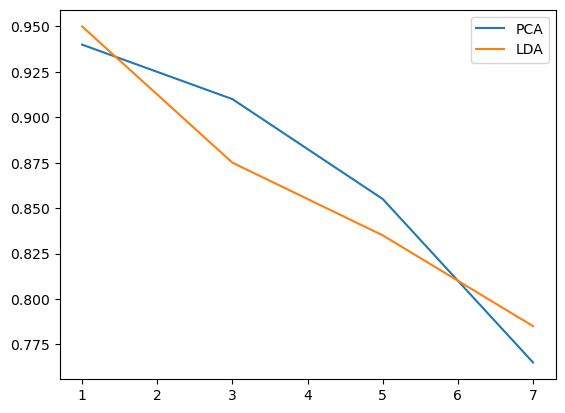

In [14]:
plt.plot(k_values, accuracies_pca, label='PCA')
plt.plot(k_values, accuracies_lda, label='LDA')
plt.legend()
plt.show()

## remember the report